# Aiyagari model
This is a test code. It seems to work well. But some mistakes may exist.

In [1]:
using Distributions
using BenchmarkTools
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
#include("tauchen.jl")
function tauchen(nz,ρ,σ,s::Int=3)
    """
    need package Distributions
    consider log(z_t) = ρlog(z_{t-1}) + ε
    define x_t = log(z_t) and we consider
    this version.

    """

    """
    Arguments:
    nz: grid size
    ρ: persistence of AR(1) process
    σ: standard diviation of random components
    s: decide maximum and minimum value of node

    return:
    z: discretized grid array{float64,1}
    Π: transition matrix of x array{float64,2}
    """
    d = Normal() # standard normal distribution
    σ_x = sqrt(σ^2/(1.0-ρ^2))
    xmin = -s*σ_x
    xmax = s*σ_x
    x = linspace(xmin,xmax,nz)
    w = x[2] -x[1] #width of each grid

    # Get transition matrix

    Π = zeros(nz,nz)

    for row in 1:nz

        # Do end points first

        @inbounds Π[row, 1] = cdf(d,(x[1] - ρ*x[row] + w/2) / σ)

        @inbounds Π[row, nz] = ccdf(d,(x[nz] - ρ*x[row] - w/2) / σ) #1.0- cdf((x[N] - ρ*x[row] - w/2) / σ)
    end

    # fill in the middle columns
    for row in 1:nz
        for col in 2:nz-1

            @inbounds Π[row, col] = (cdf(d,(x[col] - ρ*x[row] + w/2) / σ) -

                           cdf(d,(x[col] - ρ*x[row] - w/2) / σ))
        end
    end

    #we consider x=log(z_t) case. so I want to return z_t
    z = exp.(x)
    return z,Π
end


tauchen (generic function with 2 methods)

In [3]:
function Aggregate_Labor(zgrid,Π)
    const nz = size(zgrid,1)
    probst =    ones(nz)./nz
    probst1 = zeros(nz)
    err = 1.0
    const tol = 1e-5
    Trans = transpose(Π)

    while err > tol
        probst1 = Trans*probst
        err=maximum(abs.(probst1-probst))
        probst = copy(probst1)  
    end

    L = dot(probst,zgrid)
    return L
end



Aggregate_Labor (generic function with 1 method)

In [4]:
function main()
    #primitive parameter
    const β = 0.96 #subjective discount factor
    const μ = 3.0 # relative risk aversion
    const b = 3.0 # debt limit
    const α = 0.36 # capital share
    const δ = 0.08 # delta

    #discretize indivisual shock
    const σ = 0.4 # std dev of AR(1) process 
    const ρ = 0.4 # coefficient of AR(1) 
    const nz = 7
    zgrid,Π = tauchen(nz,ρ,σ)

    #calculate aggregate labor
    #invariant distribution and L
    const L = Aggregate_Labor(zgrid,Π)


    #rbisection with respect to r
    r_up = (1.0/β)-1.0
    r_low = -δ
    r = 0.0
    w = 0.0
    Ks = 0.0
    #initialization
    const na = 100
    u(c::Float64) = (c^(1.0-μ))/(1.0-μ)
    agrid::Array{Float64,1} = zeros(na)
    util = zeros(na,na,nz)
    v0 = zeros(na,nz)
    Tv = zeros(na,nz)
    a_index::Array{Int64,2} = zeros(na,nz)
    #pol_a = zeros(na,nz)
    dist0 = ones(na,nz)./(na*nz)
    dist1 = zeros(na,nz)
    
    #iteration setting
    const maxiter = 300
    const tol = 1e-5
    const neg::Float64 = -1e10
 
    #Outside　about excess demand
    for it in 1:maxiter

        r = (r_low+r_up)/2
        w = (1.0-α)*(α/(r+δ))^(α/(1.0-α))
        
        # create asset grid
        if r <= 0.0
            amin = b
        else
            amin  = min(b,(w*zgrid[1])/r)
        end
        const amax = 16.0
        agrid = linspace(-amin,amax,na)
        
        # create utility matrix
        for i in 1:na
            for j in 1:na
                for z in 1:nz
                    c = w*zgrid[z] +(1.0+r)*agrid[i] - agrid[j]
                    if c >= 0.0
                        @inbounds util[i,j,z] = u(c)
                    else
                        @inbounds util[i,j,z] = neg
                    end
                end
            end
        end
        
        # solve indivisual problem
        for VFI_it in 1: maxiter
            #EV = v0*Π'
            for z in 1:nz
                gridnext::Int64 = 1
                for i in 1:na
                    vmin = neg
                    for j in 1:na
                        v = util[i,j,z] + β*dot(Π[z,:],v0[j,:])#EV[j,z]
                        if v > vmin
                            vmin = copy(v)
                            gridnext = j
                        end
                    end
                    @inbounds Tv[i,z] = copy(vmin)
                    @inbounds a_index[i,z] = copy(gridnext)
                end
            end
            
            err = maximum(abs.(Tv-v0))
            v0 = copy(Tv)
            if err < tol
                break
            end
        end       
        #end of indivisual problem
        
        # compute distribution
        err = 1.0
            
        for dist_it in 1:maxiter# calculate the invariant distribution
            for i in 1 : na
                for j in 1 : nz
                    h = a_index[i,j]
                    for zz in 1 : nz
                        @inbounds dist1[h,zz] = dist1[h,zz]+ Π[zz,j]*dist0[i,j]
                        #dist1[h,zz] = dist1[h,zz] +Π[zz,j]*dist0[i,j]
                    end
                    #dist1[h,1] = dist1[h ,1] + Piz[1,j]*dist0[i,j]

                end
            end
            err = maximum(abs.(dist1-dist0))
            dist0 = copy(dist1)  # invariant distribution
            dist1 = zeros(na,nz)
            if err < tol
                break
            end
        end
        
        # aggregation
        Ks = 0.0
        for j in 1:na
            Ks = Ks + agrid[j]*sum(@views dist0[j,:])
        end
    
        Kd = L*(α /(r+δ)) ^(1.0/(1.0-α))
        excess = Kd - Ks

        if abs(excess) < tol
            break
        elseif excess >0.0
            r_low = r
        else
            r_up = r
        end
    end

    
    return agrid,Ks, L, r, w, dist0
end

main (generic function with 1 method)

In [5]:
agrid ,K, L,r,w,dist0 = main()

([-3.0, -2.80808, -2.61616, -2.42424, -2.23232, -2.0404, -1.84848, -1.65657, -1.46465, -1.27273  …  14.2727, 14.4646, 14.6566, 14.8485, 15.0404, 15.2323, 15.4242, 15.6162, 15.8081, 16.0], 6.466919679370049, 1.1097706241272491, 0.03786458333333341, 1.199352956973488, [0.000344042 0.000215576 … 1.2911e-5 4.79384e-6; 0.00052725 0.000426156 … 6.59369e-5 3.13084e-5; … ; 2.7029e-5 6.62995e-5 … 0.000539523 0.000676988; 8.01731e-5 0.000210391 … 0.00304422 0.00471857])

In [6]:
@time main();

 17.014318 seconds (555.00 M allocations: 41.400 GiB, 8.61% gc time)



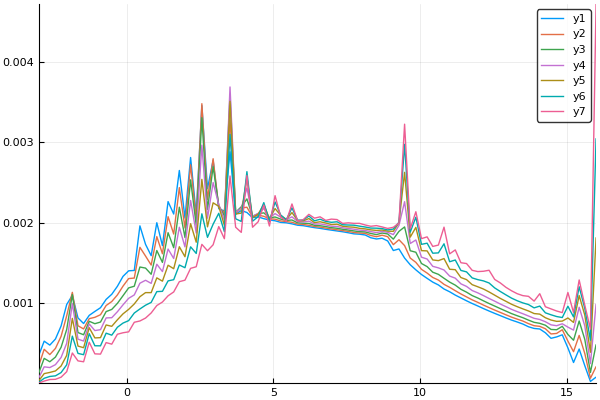

In [7]:
plot(agrid,dist0)